<a href="https://colab.research.google.com/github/deepakk7195/IISC_CDS_DS/blob/Scalable_ML_GenAI/M3_NB_MiniProject_01_MLR_MPI_OpenMP_Team_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Implementation of Multiple Linear Regression using MPI and OpenMP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Learning Objectives

At the end of the mini-project, you will be able to :

* understand the collective communication operations like scatter, gather, broadcast
* understand the blocking and non-blocking communication
* implement multiple linear regression and run it using MPI
* implement the multiple linear regression based predictions using OpenMP

### Dataset

The dataset chosen for this mini-project is [Combined Cycle Power Plant](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant). The dataset is made up of 9568 records and 5 columns. Each record contains the values for Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output.

Predicting full load electrical power output of a base load power plant is important in order to maximize the profit from the available megawatt hours.  The base load operation of a power plant is influenced by four main parameters, which are used as input variables in the dataset, such as ambient temperature, atmospheric pressure, relative humidity, and exhaust steam pressure. These parameters affect electrical power output, which is considered as the target variable.

**Note:** The data was collected over a six year period (2006-11).

## Information

#### MPI in a Nutshell

MPI stands for "Message Passing Interface". It is a library of functions (in C / Python) or subroutines (in Fortran) that you insert into source code to perform data communication between processes. MPI was developed over two years of discussions led by the MPI Forum, a group of roughly sixty people representing some forty organizations.

To know more about MPI click [here](https://hpc-tutorials.llnl.gov/mpi/)


#### Multiple Linear Regression

Multiple regression is an extension of simple linear regression. It is used when we want to predict the value of a variable based on the value of two or more other variables. The variable we want to predict is called the dependent variable (or sometimes, the outcome, target or criterion variable). The variables we are using to predict the value of the dependent variable are called the independent variables (or sometimes, the predictor, explanatory or regressor variables).

**Note:** We will be using the mpi4py Python package for MPI based code implementation

## Grading = 20 Points

**Run the below code to install mpi4py package**

In [ ]:
!pip install mpi4py

#### Importing Necessary Packages

In [ ]:
# Importing pandas
import pandas as pd
# Importing Numpy
import numpy as np
# Importing MPI from mpi4py package
from mpi4py import MPI
# Importing sqrt function from the Math
from math import sqrt
# Importing Decimal, ROUND_HALF_UP functions from the decimal package
from decimal import Decimal, ROUND_HALF_UP
import time

#### Downloading the data

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/PowerPlantData.csv

### Overview

* Load the data and perform data pre-processing
* Identify the features, target and split the data into train and test
* Implement multiple Linear Regression by estimating the coefficients on the given data
* Use MPI package to distribute the data and implement `communicator`
* Define functions for each objective and make a script (.py) file to execute using MPI command
* Use OpenMP component to predict the data and calculate the error on the predicted data
* Implement the Linear Regression from `sklearn` and compare the results

#### Exercise 1: Load data (1 point)

Write a function that takes the filename as input and loads the data in a pandas dataframe with the column names as Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output respectively.

**Hint:** read_csv()


In [ ]:
FILENAME = "/content/PowerPlantData.csv" # File path

# YOUR CODE HERE to Define a function to load the data

In [ ]:
df = pd.read_csv(FILENAME)

In [ ]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


#### Exercise 2: Explore data (1 point)

Write a function that takes the data loaded using the above defined function as input and explore it.

**Hint:** You can define and check for following things in the dataset inside a function

- checking for the number of rows and columns
- summary of the dataset
- check for the null values
- check for the duplicate values

In [ ]:
# YOUR CODE HERE for rows, columns and summary

def getNecessaryAttributesRequired(df):
    rows, columns = df.shape
    #print(rows, columns)
    summary = df.describe()

    return rows, columns, summary

r, c, s = getNecessaryAttributesRequired(df)
print(r, c, s)

9568 5                 AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000


In [ ]:
df.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [ ]:

def extractNullColumnsFromDataFrame(df):
    number_of_null_values_per_column = df.isnull().sum()
    total_number_of_null_values = number_of_null_values_per_column.sum()

    return number_of_null_values_per_column, total_number_of_null_values

null_per_column, total_number_null_vals = extractNullColumnsFromDataFrame(df)

print(null_per_column, total_number_null_vals)


AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64 0


#### Exercise 3: Handle missing data (1 point)

After exploring the dataset if there are any null values present in the dataset then define a function that takes data loaded using the above defined function as input and handle the null values accordingly.

**Hint:**

- Drop the records containing the null values - dropna()
- Replace the null values with the mean/median/mode - fillna()

In [ ]:
# Function to handle missing data

# YOUR CODE HERE

# Comment: Nothing is required here.

#### Exercise 4: Scale the data (1 point)

Write a function that takes the data after handling the missing data as input and returns the standardized data.

**Hint:**

- standardization of the data  can be performed using the below formula

$ (x - mean(x)) / std(x) $

In [ ]:
# Defining a function to standardize the data

def standardizeExceptTarget(df):
  """
  Standardizes the data in a Pandas DataFrame.

  Args:
      df (pandas.DataFrame): The DataFrame to standardize.

  Returns:
      pandas.DataFrame: The standardized DataFrame.
  """
  result = df.copy()  # Create a copy to avoid modifying the original DataFrame
  for col in ['AT', 'V', 'AP', 'RH']:
    if pd.api.types.is_numeric_dtype(result[col]):  # Check for numeric columns
      # Calculate mean and standard deviation
      mean = result[col].mean()
      std = result[col].std()
      # Standardize the data (subtract mean and divide by standard deviation)
      result[col] = (result[col] - mean) / std
  return result

def standardize(df):
  """
  Standardizes the data in a Pandas DataFrame.

  Args:
      df (pandas.DataFrame): The DataFrame to standardize.

  Returns:
      pandas.DataFrame: The standardized DataFrame.
  """
  result = df.copy()  # Create a copy to avoid modifying the original DataFrame
  for col in result.columns:
    if pd.api.types.is_numeric_dtype(result[col]):  # Check for numeric columns
      # Calculate mean and standard deviation
      mean = result[col].mean()
      std = result[col].std()
      # Standardize the data (subtract mean and divide by standard deviation)
      result[col] = (result[col] - mean) / std
  return result

#df_standardized = standardize(df.copy())
#print(df_standardized)

#df = df_standardized

df_standardized1 = standardizeExceptTarget(df.copy())
print(df_standardized1)

df = df_standardized1


# YOUR CODE HERE

            AT         V        AP        RH      PE
0    -1.517782 -1.065149 -0.407336  1.143885  480.48
1     0.535228  0.329260 -0.313040  0.061028  445.75
2     1.353748  0.204141 -1.028675 -2.150575  438.76
3    -0.077992 -0.363223 -1.016888  0.238422  453.09
4    -1.053507 -1.073805  0.651804  1.636341  464.43
...        ...       ...       ...       ...     ...
9563 -0.608017 -0.423816 -0.245686 -0.025957  462.59
9564  1.846202  1.860591 -0.498263 -0.930735  432.90
9565 -0.491277 -0.862913  0.158437  0.366502  465.96
9566 -0.268532  0.437854  0.895962  1.461687  450.93
9567  0.540595 -0.236530 -0.235583 -0.141708  451.67

[9568 rows x 5 columns]


#### Exercise 5: Feature selection (1 point)

Write a function that takes scaled data as input and returns the features and target variable values

**Hint:**

- Features: AmbientTemperature, ExhaustVaccum, AmbientPressure, RelativeHumidity
- Target Variable: EnergyOutput

In [ ]:
# Define a function
def select_X_y(df):
  """
  Extracts features (X) and target variable (y) from a DataFrame.

  Args:
      df (pandas.DataFrame): The DataFrame containing features and target variable.

  Returns:
      tuple: A tuple containing two DataFrames:
          - X: The DataFrame containing features (all columns except the last).
          - y: The DataFrame containing the target variable (last column).
  """
  X = df.iloc[:, :-1]  # Select all columns except the last
  y = df.iloc[:, -1]  # Select the last column
  return X, y

# Example usage (assuming your DataFrame is named 'df')
X, y = select_X_y(df.copy())

# YOUR CODE HERE

In [ ]:
print(X, y)

            AT         V        AP        RH
0    -1.517782 -1.065149 -0.407336  1.143885
1     0.535228  0.329260 -0.313040  0.061028
2     1.353748  0.204141 -1.028675 -2.150575
3    -0.077992 -0.363223 -1.016888  0.238422
4    -1.053507 -1.073805  0.651804  1.636341
...        ...       ...       ...       ...
9563 -0.608017 -0.423816 -0.245686 -0.025957
9564  1.846202  1.860591 -0.498263 -0.930735
9565 -0.491277 -0.862913  0.158437  0.366502
9566 -0.268532  0.437854  0.895962  1.461687
9567  0.540595 -0.236530 -0.235583 -0.141708

[9568 rows x 4 columns] 0       480.48
1       445.75
2       438.76
3       453.09
4       464.43
         ...  
9563    462.59
9564    432.90
9565    465.96
9566    450.93
9567    451.67
Name: PE, Length: 9568, dtype: float64


#### Exercise 6: Correlation (1 point)

Calculate correlation between the variables

In [ ]:
# YOUR CODE HERE
# Pearson correlation (default)
pearson_corr = df.corr()

# Spearman's rank correlation
spearman_corr = df.corr(method='spearman')

# Kendall's rank correlation
kendall_corr = df.corr(method='kendall')

print("Pearson correlation:")
print(pearson_corr)

print("\nSpearman's rank correlation:")
print(spearman_corr)

print("\nKendall's rank correlation:")
print(kendall_corr)

Pearson correlation:
          AT         V        AP        RH        PE
AT  1.000000  0.844107 -0.507549 -0.542535 -0.948128
V   0.844107  1.000000 -0.413502 -0.312187 -0.869780
AP -0.507549 -0.413502  1.000000  0.099574  0.518429
RH -0.542535 -0.312187  0.099574  1.000000  0.389794
PE -0.948128 -0.869780  0.518429  0.389794  1.000000

Spearman's rank correlation:
          AT         V        AP        RH        PE
AT  1.000000  0.850620 -0.518790 -0.542706 -0.944412
V   0.850620  1.000000 -0.426129 -0.304938 -0.883702
AP -0.518790 -0.426129  1.000000  0.086776  0.542531
RH -0.542706 -0.304938  0.086776  1.000000  0.389640
PE -0.944412 -0.883702  0.542531  0.389640  1.000000

Kendall's rank correlation:
          AT         V        AP        RH        PE
AT  1.000000  0.644291 -0.360763 -0.377179 -0.795787
V   0.644291  1.000000 -0.294533 -0.202913 -0.684200
AP -0.360763 -0.294533  1.000000  0.058466  0.381276
RH -0.377179 -0.202913  0.058466  1.000000  0.263391
PE -0.795787 -0.684

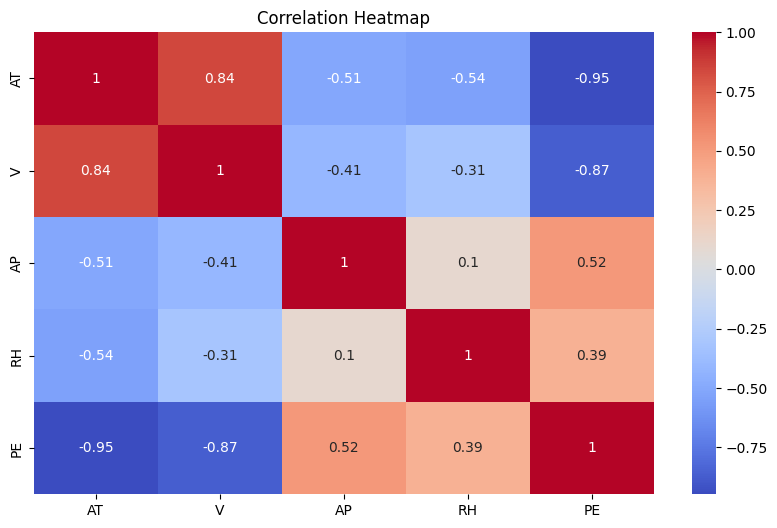

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot():
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')  # Customize colormap if desired
    plt.title("Correlation Heatmap")
    plt.show()

plot()

#### Exercise 7: Estimate the coefficients (2 points)

Write a function that takes features and target as input and returns the estimated coefficient values

**Hint:**

- Calculate the estimated coefficients using the below formula

$ β = (X^T X)^{-1} X^T y $

- transpose(), np.linalg.inv()

In [ ]:
# Calculating the coeffients

# YOUR CODE HERE

def calculate_beta(X, y):
  """
  Calculates the beta coefficient using the formula β = (X^T * X)^-1 * X^T * y.

  Args:
      X (numpy.ndarray): The features matrix (2D array).
      y (numpy.ndarray): The target variable (1D array).

  Returns:
      numpy.ndarray: The beta coefficient vector.
  """
  # Calculate transpose of X
  X_transpose = X.T

  # Calculate pseudo-inverse of (X^T * X) using np.linalg.pinv for better stability
  X_pinv = np.linalg.pinv(X_transpose.dot(X))

  # Calculate beta using the formula
  beta = X_pinv.dot(X_transpose.dot(y))

  return beta

  # Usage
beta = calculate_beta(X, y)

print("Beta coefficient: {}".format(beta.size))
print(beta)

Beta coefficient: 4
[-14.73736349  -2.97258487   0.36869717  -2.30763238]


#### Exercise 8: Fit the data to estimate the coefficients (2 points)

Write a function named fit which takes features and targets as input and returns the intercept and coefficient values.

**Hint:**

- create a dummy column in the features dataframe which is made up of all ones
- convert the features dataframe into numpy array
- call the estimated coefficients function which is defined above
- np.ones(), np.concatenate()

In [ ]:
# defining a fit function

def estimated_coefficients(X, y):
  """
  Calculates the estimated coefficients for linear regression using the closed-form solution.

  Args:
      X (numpy.ndarray): The features matrix (2D array).
      y (numpy.ndarray): The target variable vector (1D array).

  Returns:
      numpy.ndarray: The estimated coefficients vector.
  """

  # Calculate the transpose of X
  X_transpose = X.T

  # Calculate the coefficients using the closed-form solution
  coefficients = np.linalg.pinv(X_transpose.dot(X)).dot(X_transpose.dot(y))

  return coefficients

def fit(features, target):
  """
  Fits a linear regression model and returns the intercept and coefficients.

  Args:
      features (pandas.DataFrame): The DataFrame containing features.
      target (pandas.Series): The Series containing the target variable.

  Returns:
      tuple: A tuple containing the intercept (float) and coefficients (numpy.ndarray).
  """

  # Add a dummy column of ones for the intercept
  #features['intercept'] = 1  # Add a column of ones
  features.insert(0, 'intercept',1)

  # Convert features to a NumPy array
  X1 = features.to_numpy()

  # Call the estimated coefficients function (assuming it's defined elsewhere)
  #coefficients = estimated_coefficients(X, target)  # Replace with your coefficients function
  coefficients = calculate_beta(X1, target)
  print(coefficients)

  # Separate intercept and coefficients
  intercept = coefficients[0]
  coefficients = coefficients[1:]

  return intercept, coefficients

# Example usage (assuming you have features and target)
intercept, coefficients = fit(X.copy(), y.copy())
#intercept, coefficients = fit(X, y)

print("Intercept:", intercept)
print("Coefficients:", coefficients)

[ 4.54365009e+02 -1.47373635e+01 -2.97258487e+00  3.68697175e-01
 -2.30763238e+00]
Intercept: 454.3650094063546
Coefficients: [-14.73736349  -2.97258487   0.36869717  -2.30763238]


In [ ]:
print(beta)

[-14.73736349  -2.97258487   0.36869717  -2.30763238]


#### Exercise 9: Predict the data on estimated coefficients (1 point)

Write a function named predict which takes features, intercept and coefficient values as input and returns the predicted values.

**Hint:**

- Fit the intercept, coefficients values in the below equation

  $y = b_0 + b_1*x + ... + b_i*x_i$

In [ ]:
X.head()

,AT,V,AP,RH
0,-1.517782,-1.065149,-0.407336,1.143885
1,0.535228,0.329260,-0.313040,0.061028
2,1.353748,0.204141,-1.028675,-2.150575
3,-0.077992,-0.363223,-1.016888,0.238422
4,-1.053507,-1.073805,0.651804,1.636341


In [ ]:
X.shape

(9568, 4)

In [ ]:
rows, cols = X.shape

In [ ]:
print(rows, cols)

9568 4


In [ ]:
 # fucntion to predict the values

def predictMP(X1, intercept, coefficients):
  """
  Predicts target values for new features using a linear regression model.
  y = b_0 + b_1*x + ... + b_i*x_i
  Args:
      X (numpy.ndarray): The features matrix (2D array) for new data points.
      coefficients (numpy.ndarray): The model coefficients (1D array).

  Returns:
      numpy.ndarray: The predicted target values (1D array).
  """

  # Add a column of ones for the intercept term (if not already included)
  #if X1.shape[1] != len(coefficients):
    #X1 = np.concatenate((X1, np.ones((X1.shape[0], 1))), axis=1)
    #print('if condition was executed')

  intercept_array = np.full(X1.shape[0], intercept)
  # Calculate predicted target values
  y_pred = X1.dot(coefficients) + intercept_array

  return y_pred

In [ ]:
 # fucntion to predict the values

def predict(X1, intercept, coefficients):
  """
  Predicts target values for new features using a linear regression model.
  y = b_0 + b_1*x + ... + b_i*x_i
  Args:
      X (numpy.ndarray): The features matrix (2D array) for new data points.
      coefficients (numpy.ndarray): The model coefficients (1D array).

  Returns:
      numpy.ndarray: The predicted target values (1D array).
  """

  # Add a column of ones for the intercept term (if not already included)
  if X1.shape[1] != len(coefficients):
    X1 = np.concatenate((X1, np.ones((X1.shape[0], 1))), axis=1)
    print('if condition was executed')

  intercept_array = np.full(X1.shape[0], intercept)
  # Calculate predicted target values
  y_pred = X1.dot(coefficients) + intercept_array

  return y_pred

i = intercept
c = coefficients



In [ ]:
print(i.shape)
print(c.shape)

()
(4,)


In [ ]:
y_hat = predict(X, i, c )

In [ ]:
print(y_hat)

0       477.109516
1       445.242168
2       438.390979
3       455.669000
4       469.547144
           ...    
9563    464.554722
9564    423.590183
9565    463.382888
9566    453.978216
9567    447.341325
Length: 9568, dtype: float64


#### Exercise 10: Root mean squared error (1 point)

Write a function to calculate the RMSE error.

**Hint:**

- [How to calculate the RSME error](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e)

In [ ]:
# Define a function to calculate the error

# YOUR CODE HERE

def calculateRMSE(y_true, y_pred):
  """
  Calculates the Root Mean Squared Error (RMSE) between true and predicted values.

  Args:
      y_true (numpy.ndarray): The ground truth target values (1D array).
      y_pred (numpy.ndarray): The predicted target values (1D array).

  Returns:
      float: The Root Mean Squared Error (RMSE).
  """

  # Calculate squared errors
  squared_errors = np.square(y_true - y_pred)

  # Mean squared error
  mse = np.mean(squared_errors)

  # Root Mean Squared Error
  rmse = np.sqrt(mse)

  return rmse



In [ ]:

rmse_error = calculateRMSE(y, y_hat)

In [ ]:
print(rmse_error)

4.557126016749484


#### Exercise 11: Split the data into train and test (1 point)

Write a function named train_test_split which takes features and targets as input and returns the train and test sets respectively.

**Hint:**

- Shuffle the data
- Consider 70 % of data as a train set and the rest of the data as a test set

In [ ]:
# YOUR CODE HERE
from sklearn.utils import shuffle

def train_test_split(features, targets, test_size=0.3, random_state=None):
  """
  Splits features and targets into training and testing sets.

  Args:
      features (numpy.ndarray): The features matrix (2D array).
      targets (numpy.ndarray): The target values array (1D array).
      test_size (float, optional): Proportion of the data for the test set. Defaults to 0.3 (30%).
      random_state (int, optional): Seed for shuffling the data before splitting. Defaults to None.

  Returns:
      tuple: A tuple of four NumPy arrays containing the training and testing splits for features and targets.
          (X_train, X_test, y_train, y_test)
  """

  # Shuffle data (important for unbiased splitting)
  features, targets = shuffle(features, targets, random_state=random_state)

  # Split data into training and testing sets
  split_index = int(len(features) * (1 - test_size))
  X_train, X_test = features[:split_index], features[split_index:]
  y_train, y_test = targets[:split_index], targets[split_index:]

  return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
X_test.shape

(2871, 4)

In [ ]:

y_test_hat = predict(X_test, intercept, coefficients )

rmse_test = calculateRMSE(y_test_hat, y_test)

In [ ]:
print(rmse_test)

4.52706700571005


#### Exercise 12: Implement predict using OpenMP (1 point)

Get the predictions for test data and calculate the test error(RMSE) by implementing the OpenMP (pymp)

**Hints:**

* Using the pymp.Parallel implement the predict function (use from above)

* Call the predict function by passing test data as an argument

* calculate the error (RMSE) by comparing the Actual test data and predicted test data

In [ ]:
!pip -qq install pymp-pypi

In [ ]:

import pymp
from pymp import Parallel
from pymp import shared

In [ ]:
def predictMP1(X1, intercept, coefficients):
  """
  Predicts target values for new features using a linear regression model.
  y = b_0 + b_1*x + ... + b_i*x_i
  Args:
      X (numpy.ndarray): The features matrix (2D array) for new data points.
      coefficients (numpy.ndarray): The model coefficients (1D array).

  Returns:
      numpy.ndarray: The predicted target values (1D array).
  """

  # Add a column of ones for the intercept term (if not already included)
  y_pred = X1.dot(coefficients) + intercept

  return y_pred

In [ ]:
# Parallelize prediction
# Working Code
num_threads = 4
predictions = pymp.shared.array(len(X_test), dtype=int)


# Function to make predictions on a subset of the data
def predict_subset(start_idx, end_idx, data, predictions):
    for i in range(start_idx, end_idx):
        predictions[i] = predictMP1(data.iloc[i], intercept, coefficients)


with pymp.Parallel(num_threads) as p:
    start_idx = p.thread_num * (len(X_test) // num_threads)
    end_idx = start_idx + (len(X_test) // num_threads) + (len(X_test) % num_threads)
    predict_subset(start_idx, end_idx, X_test, predictions)

# Aggregate results
# shared array and lists are possible checks to be done
# compare with sklearn
# dot products via columns
final_predictions = list(predictions)


In [ ]:
print(final_predictions)

[449, 442, 479, 435, 447, 429, 430, 482, 463, 461, 479, 439, 448, 466, 430, 428, 427, 466, 429, 437, 456, 447, 449, 461, 429, 425, 467, 467, 446, 461, 444, 454, 459, 475, 448, 468, 461, 431, 465, 438, 467, 429, 463, 436, 448, 473, 433, 442, 456, 464, 425, 438, 438, 438, 466, 439, 452, 450, 447, 441, 445, 446, 427, 457, 444, 454, 431, 465, 426, 442, 455, 463, 438, 438, 461, 440, 474, 469, 463, 472, 456, 441, 450, 441, 472, 430, 466, 443, 448, 449, 430, 472, 472, 452, 445, 428, 439, 442, 459, 474, 482, 459, 438, 432, 446, 424, 453, 459, 476, 473, 451, 460, 462, 437, 452, 432, 436, 441, 444, 460, 468, 455, 435, 432, 442, 471, 450, 449, 475, 461, 430, 443, 436, 446, 467, 444, 443, 425, 472, 472, 445, 444, 460, 460, 481, 431, 474, 454, 470, 439, 439, 454, 459, 458, 444, 470, 476, 433, 444, 447, 470, 483, 478, 466, 422, 456, 428, 441, 473, 436, 472, 475, 465, 456, 473, 474, 466, 481, 471, 460, 477, 446, 467, 466, 440, 431, 464, 451, 464, 432, 460, 447, 493, 434, 452, 451, 480, 437, 451, 476,

In [ ]:
predictions.shape
pred_mp = np.full(predictions.shape[0], predictions)

In [ ]:
print(pred_mp)

[449 442 479 ... 441 439 481]


In [ ]:
rmse_using_pymp = calculateRMSE(pred_mp, y_test)
print(rmse_using_pymp)

4.553983952133997


In [ ]:
#num_threads = 100

# Assuming X_test is your pandas dataframe
#X_test_array = X_test.to_numpy()  # Convert dataframe to NumPy array

#with pymp.Parallel(num_threads) as p:
    #print(type(p))
    #shared_X_test = pymp.shared.array(X_test_array)  # Share the NumPy array
    #y_pred_local = predict(X_test, intercept, coefficients)


#master_array = 0
'''
shared_array = pymp.shared.array((2891,), dtype='int32')

def convertForMP(num_threads1):
    num_threads = num_threads1

    # Assuming X_test is your pandas dataframe
    X_test_array = X_test.to_numpy()  # Convert dataframe to NumPy array

    with pymp.Parallel(num_threads) as p:
        print(type(p))
        #shared_X_test = pymp.shared.array(X_test_array)  # Share the NumPy array
        y_pred_local = predict(X_test, intercept, coefficients)
        #shared_array.append(y_pred_local)


convertForMP(100)

print(shared_array)

# Further processing of y_pred_local (if needed)
'''

"\nshared_array = pymp.shared.array((2891,), dtype='int32')\n\ndef convertForMP(num_threads1):\n    num_threads = num_threads1\n\n    # Assuming X_test is your pandas dataframe\n    X_test_array = X_test.to_numpy()  # Convert dataframe to NumPy array\n\n    with pymp.Parallel(num_threads) as p:\n        print(type(p))\n        #shared_X_test = pymp.shared.array(X_test_array)  # Share the NumPy array\n        y_pred_local = predict(X_test, intercept, coefficients)\n        #shared_array.append(y_pred_local)\n\n\nconvertForMP(100)\n\nprint(shared_array)\n\n# Further processing of y_pred_local (if needed)\n"

In [ ]:
!pip install pymp-pypi

In [ ]:
import pymp
# YOUR CODE HERE
# Importing pandas
import pandas as pd
# Importing Numpy
import numpy as np
# Importing MPI from mpi4py package
from mpi4py import MPI
# Importing sqrt function from the Math
from math import sqrt
# Importing Decimal, ROUND_HALF_UP functions from the decimal package
from decimal import Decimal, ROUND_HALF_UP
import time
from sklearn import datasets

In [ ]:
!pip -qq install mpi4py

#### Exercise 13: Create a communicator (1 point)

Create a comunicator and define the rank and size

In [ ]:
%%writefile rank.py
from mpi4py import MPI # Importing mpi4py package from MPI module

# Define a function


# end of the function

def main():
    # creating the communicator
    comm = MPI.COMM_WORLD
    # number of the process running the code i.e rank
    rank = comm.Get_rank()
    # total number of processes running i.e size
    size = comm.Get_size()
    # Displaying the rank and size of a communicator
    print("rank is {} and size is {}".format(rank,size))

# invoke the function
main()

Overwriting rank.py


In [ ]:
from mpi4py import MPI

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    # Only the root process prints
    if rank == 0:
        print("rank is {} and size is {}".format(rank, size))

    # Add barrier to ensure output flushing
    comm.Barrier()
    MPI.Finalize()

if __name__ == "__main__":
    main()


rank is 0 and size is 1


In [ ]:
!mpirun --allow-run-as-root --oversubscribe -np 4 python rank.py

rank is 0 and size is 4
rank is 2 and size is 4
rank is 3 and size is 4
rank is 1 and size is 4


In [ ]:
%%writefile rank_miniproject.py
from mpi4py import MPI
def main():
    # YOUR CODE HERE# Creating a communicator
    comm = MPI.COMM_WORLD
    # number of the process running the code
    rank = comm.Get_rank()
    # total number of processes running
    size = comm.Get_size()
    #return rank, size
    print("rank is {} and size is {}".format(rank,size))
    #master process
    if rank == 0:
        # Generate a dictionary with arbitrary data in it
        data = 129
        # master process sends data to worker processes by
        # going through the ranks of all worker processes
        for i in range(1, size):
            # Sending data
            comm.send(data, dest=i, tag=i)
            # Displaying the results
            print('Process {} sent data:'.format(rank), data)
    # worker processes
    else:
        # each worker process receives data from master process
        data = comm.recv(source=0, tag=rank)
        # Displaying the results
        print('Process {} received data:'.format(rank), data)

main()


Overwriting rank_miniproject.py


In [ ]:
!mpirun --allow-run-as-root --oversubscribe -np 4 python rank_miniproject.py

rank is 2 and size is 4
rank is 1 and size is 4
rank is 3 and size is 4
rank is 0 and size is 4
Process 0 sent data: 129
Process 1 received data: 129
Process 0 sent data: 129
Process 2 received data: 129
Process 0 sent data: 129
Process 3 received data: 129


#### Exercise 14: Divide the data into slices (1 point)

Write a function named dividing_data which takes train features set, train target set, and size of workers as inputs and returns the sliced data for each worker.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/MiniProject_MPI_DataSlice.JPG)

For Example, if there are 4 processes, slice the data into 4 equal parts with 25% ratio

**Hint:**

- Divide the Data equally among the workers
  - Create an empty list
  - Iterate over the size of workers
  - Append each slice of data to the list

In [ ]:
def dividing_data0(x_train, y_train, size_of_workers):
    # Size of the slice
    slice_for_each_worker = int(Decimal(x_train.shape[0]/size_of_workers).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))
    # YOUR CODE HERE


In [ ]:
masterlist = []
t1 = ()

In [ ]:
features_slice1 = []
target_slice1 = []

def dividing_data(train_features, train_target, num_workers):
    # Calculate the number of samples per worker
    samples_per_worker = len(train_features) // num_workers

    # Create an empty list to store sliced data for each worker
    sliced_data = []

    # Iterate over the number of workers
    for i in range(num_workers):
        # Calculate the start and end indices for slicing the data
        start_idx = i * samples_per_worker
        end_idx = (i + 1) * samples_per_worker if i < num_workers - 1 else None

        # Slice the train features and train target data for the current worker
        features_slice = train_features[start_idx:end_idx]
        target_slice = train_target[start_idx:end_idx]

        features_slice1 = train_features[start_idx:end_idx]
        target_slice1 = train_target[start_idx:end_idx]

        t1 = (features_slice1, target_slice1)
        masterlist.append(t1)

        # Append the sliced data to the list
        sliced_data.append((features_slice, target_slice))


    return sliced_data



In [ ]:
sliced_data = dividing_data(X_train, y_train, 4)

In [ ]:
sliced_data

[(            AT         V        AP        RH
  8369 -1.006543 -1.221745  0.013626  1.489084
  5576  1.428891  1.196437 -0.245686 -1.567024
  353  -1.372864 -1.015574  2.751560  0.967175
  7296  1.584544  1.799212 -0.673383 -0.938269
  4462  1.088064  1.438019 -0.710428  0.798001
  ...        ...       ...       ...       ...
  1957  0.054850  0.613335  1.170429 -0.075271
  1708 -1.706981 -1.036034  2.344070  0.778138
  3112 -0.794532 -0.974654  2.988983 -0.574577
  6111  0.843850  1.804721 -0.890600  0.788412
  8054  1.227615  1.236570 -0.420806 -1.623188
  
  [1674 rows x 4 columns],
  8369    474.15
  5576    431.12
  353     478.12
  7296    435.56
  4462    429.25
           ...  
  1957    451.81
  1708    479.06
  3112    466.29
  6111    432.88
  8054    435.45
  Name: PE, Length: 1674, dtype: float64),
 (            AT         V        AP        RH
  5708  0.778100  1.238144 -0.346717  0.628141
  4326 -0.398691 -0.090165  0.178643  0.322667
  1785  0.618421  1.196437  0.02878

In [ ]:
#print(masterlist)
tp1 = masterlist[0]
(a,b) = tp1
print(a)

            AT         V        AP        RH
8369 -1.006543 -1.221745  0.013626  1.489084
5576  1.428891  1.196437 -0.245686 -1.567024
353  -1.372864 -1.015574  2.751560  0.967175
7296  1.584544  1.799212 -0.673383 -0.938269
4462  1.088064  1.438019 -0.710428  0.798001
...        ...       ...       ...       ...
1957  0.054850  0.613335  1.170429 -0.075271
1708 -1.706981 -1.036034  2.344070  0.778138
3112 -0.794532 -0.974654  2.988983 -0.574577
6111  0.843850  1.804721 -0.890600  0.788412
8054  1.227615  1.236570 -0.420806 -1.623188

[1674 rows x 4 columns]


In [ ]:
print(b)

8369    474.15
5576    431.12
353     478.12
7296    435.56
4462    429.25
         ...  
1957    451.81
1708    479.06
3112    466.29
6111    432.88
8054    435.45
Name: PE, Length: 1674, dtype: float64


In [ ]:
len(masterlist)
tp1

(            AT         V        AP        RH
 8369 -1.006543 -1.221745  0.013626  1.489084
 5576  1.428891  1.196437 -0.245686 -1.567024
 353  -1.372864 -1.015574  2.751560  0.967175
 7296  1.584544  1.799212 -0.673383 -0.938269
 4462  1.088064  1.438019 -0.710428  0.798001
 ...        ...       ...       ...       ...
 1957  0.054850  0.613335  1.170429 -0.075271
 1708 -1.706981 -1.036034  2.344070  0.778138
 3112 -0.794532 -0.974654  2.988983 -0.574577
 6111  0.843850  1.804721 -0.890600  0.788412
 8054  1.227615  1.236570 -0.420806 -1.623188
 
 [1674 rows x 4 columns],
 8369    474.15
 5576    431.12
 353     478.12
 7296    435.56
 4462    429.25
          ...  
 1957    451.81
 1708    479.06
 3112    466.29
 6111    432.88
 8054    435.45
 Name: PE, Length: 1674, dtype: float64)

#### Exercise 15: Prepare the data in root worker to assign data for all the workers (1 point)

- When it is the root worker, perform the below operation:
    - Store the features and target values in separate variables
    - Split the data into train and test sets using the train_test_split function defined above
    - Divide the data among the workers using the dividing_data function above

In [ ]:

%%writefile prepareData.py
from mpi4py import MPI
import pandas as pd
# Importing Numpy
import numpy as np
# Importing MPI from mpi4py package
from mpi4py import MPI
# Importing sqrt function from the Math
from math import sqrt
# Importing Decimal, ROUND_HALF_UP functions from the decimal package
from decimal import Decimal, ROUND_HALF_UP
import time

from sklearn.utils import shuffle

# start function block

# Note: Scaled data save it to the csv file and load the data.

FILENAME = "/content/PowerPlantData.csv"
df = pd.read_csv(FILENAME)

def getNecessaryAttributesRequired(df):
    rows, columns = df.shape
    #	print(rows, columns)
    summary = df.describe()
    return rows, columns, summary

def extractNullColumnsFromDataFrame(df):
    number_of_null_values_per_column = df.isnull().sum()
    total_number_of_null_values = number_of_null_values_per_column.sum()
    return number_of_null_values_per_column, total_number_of_null_values


def standardizeExceptTarget(df):
    result = df.copy()  # Create a copy to avoid modifying the original DataFrame
    for col in ['AT', 'V', 'AP', 'RH']:
        if pd.api.types.is_numeric_dtype(result[col]):  # Check for numeric columns
            # Calculate mean and standard deviation
            mean = result[col].mean()
            std = result[col].std()
            # Standardize the data (subtract mean and divide by standard deviation)
            result[col] = (result[col] - mean) / std
    return result

def select_X_y(df):
    X = df.iloc[:, :-1]  # Select all columns except the last
    y = df.iloc[:, -1]  # Select the last column
    return X, y


r, c, s = getNecessaryAttributesRequired(df)
print(r, c, s)
null_per_column, total_number_null_vals = extractNullColumnsFromDataFrame(df)
print(null_per_column, total_number_null_vals)

df_standardized1 = standardizeExceptTarget(df.copy())
print(df_standardized1)
df = df_standardized1
# Example usage (assuming your DataFrame is named 'df')
X, y = select_X_y(df.copy())


# end function block

def train_test_split(features, targets, test_size=0.3, random_state=None):
  """
  Splits features and targets into training and testing sets.

  Args:
      features (numpy.ndarray): The features matrix (2D array).
      targets (numpy.ndarray): The target values array (1D array).
      test_size (float, optional): Proportion of the data for the test set. Defaults to 0.3 (30%).
      random_state (int, optional): Seed for shuffling the data before splitting. Defaults to None.

  Returns:
      tuple: A tuple of four NumPy arrays containing the training and testing splits for features and targets.
          (X_train, X_test, y_train, y_test)
  """

  # Shuffle data (important for unbiased splitting)
  features, targets = shuffle(features, targets, random_state=random_state)

  # Split data into training and testing sets
  split_index = int(len(features) * (1 - test_size))
  X_train, X_test = features[:split_index], features[split_index:]
  y_train, y_test = targets[:split_index], targets[split_index:]

  return X_train, X_test, y_train, y_test

masterlist1 = []
t11 = ()
features_slice1 = []
target_slice1 = []

def dividing_data(train_features, train_target, num_workers):
    # Calculate the number of samples per worker
    samples_per_worker = len(train_features) // num_workers

    # Create an empty list to store sliced data for each worker
    sliced_data = []

    # Iterate over the number of workers
    for i in range(num_workers):
        # Calculate the start and end indices for slicing the data
        start_idx = i * samples_per_worker
        end_idx = (i + 1) * samples_per_worker if i < num_workers - 1 else None

        # Slice the train features and train target data for the current worker
        features_slice = train_features[start_idx:end_idx]
        target_slice = train_target[start_idx:end_idx]

        features_slice1 = train_features[start_idx:end_idx]
        target_slice1 = train_target[start_idx:end_idx]

        t11 = (features_slice1, target_slice1)
        masterlist1.append(t11)

        # Append the sliced data to the list
        sliced_data.append((features_slice, target_slice))

    return sliced_data


# YOUR CODE HERE
def prepareDataAtRootAndSendToEveryBody(X, y):
    # YOUR CODE HERE# Creating a communicator
    comm = MPI.COMM_WORLD
    # number of the process running the code
    rank = comm.Get_rank()
    # total number of processes running
    size = comm.Get_size()
    #return rank, size
    print(rank, size)
    # master process
    if rank == 0:
        # Generate a dictionary with arbitrary data in it

        X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y)

        silced_data1 = dividing_data(X_train1, y_train1, size)
        print(silced_data1)

        # for item in masterlist:
        #     # each of this tuple contains feature and test data
        #     comm.send(item, dest=i, tag=i)

        #     # Displaying the results
        #     print('Process {} sent data:'.format(rank), item)
        #     print(item)

        # # master process sends data to worker processes by
        # # going through the ranks of all worker processes

        # for i in range(1, size):
        #     # Sending data
        #     comm.send(silced_data1, dest=i, tag=i)

        #     # Displaying the results
        #     print('Process {} sent data:'.format(rank), silced_data1)

    # worker processes
    else:
        # each worker process receives data from master process
        # item = comm.recv(source=0, tag=rank)
        print('Process {} else rank:'.format(rank))

prepareDataAtRootAndSendToEveryBody(X, y)

Overwriting prepareData.py


In [ ]:
!mpirun --allow-run-as-root --oversubscribe -np 4 python prepareData.py

9568 5                 AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000
AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64 0
            AT         V        AP        RH      PE
0    -1.517782 -1.065149 -0.407336  1.143885  480.48
1     0.535228  0.329260 -0.313040  0.061028  445.75
2     1.353748  0.204141 -1.028675 -2.150575  438.76
3    -0.077992 -0.363223 -1.016888  0.238422  453.09
4    -1.053507 -1.073805  0.651804

#### Exercise 16: Scatter and gather the data (1 point)

Perform the below operations:

- Send slices of the training set(the features data X and the expected target data Y) to every worker including the root worker
    - **Hint:** scatter()
    - use `barrier()` to block workers until all workers in the group reach a Barrier, to scatter from root worker.
- Every worker should get the predicted target Y(yhat) for each slice
- Get the new coefficient of each instance in a slice
    - **Hint:** fit function defined above
- Gather the new coefficient from each worker
    - **Hint:** gather()
    - Take the mean of the gathered coefficients
- Calculate the root mean square error for the test set

To know more about `scatter`, `gather` and `barrier` click [here](https://nyu-cds.github.io/python-mpi/05-collectives/)

In [ ]:
%%writefile scatter1.py
from os import sendfile
# YOUR CODE HERE


from mpi4py import MPI
import pandas as pd
# Importing Numpy
import numpy as np
# Importing MPI from mpi4py package
from mpi4py import MPI
# Importing sqrt function from the Math
from math import sqrt
# Importing Decimal, ROUND_HALF_UP functions from the decimal package
from decimal import Decimal, ROUND_HALF_UP
import time

from sklearn.utils import shuffle

# start function block

# Note: Scaled data save it to the csv file and load the data.

FILENAME = "/content/PowerPlantData.csv"
df = pd.read_csv(FILENAME)

def getNecessaryAttributesRequired(df):
    rows, columns = df.shape
    #	print(rows, columns)
    summary = df.describe()
    return rows, columns, summary

def extractNullColumnsFromDataFrame(df):
    number_of_null_values_per_column = df.isnull().sum()
    total_number_of_null_values = number_of_null_values_per_column.sum()
    return number_of_null_values_per_column, total_number_of_null_values


def standardizeExceptTarget(df):
    result = df.copy()  # Create a copy to avoid modifying the original DataFrame
    for col in ['AT', 'V', 'AP', 'RH']:
        if pd.api.types.is_numeric_dtype(result[col]):  # Check for numeric columns
            # Calculate mean and standard deviation
            mean = result[col].mean()
            std = result[col].std()
            # Standardize the data (subtract mean and divide by standard deviation)
            result[col] = (result[col] - mean) / std
    return result

def select_X_y(df):
    X = df.iloc[:, :-1]  # Select all columns except the last
    y = df.iloc[:, -1]  # Select the last column
    return X, y


r, c, s = getNecessaryAttributesRequired(df)
print(r, c, s)
null_per_column, total_number_null_vals = extractNullColumnsFromDataFrame(df)
print(null_per_column, total_number_null_vals)

df_standardized1 = standardizeExceptTarget(df.copy())
print(df_standardized1)
df = df_standardized1
# Example usage (assuming your DataFrame is named 'df')
X, y = select_X_y(df.copy())


# end function block

def train_test_split(features, targets, test_size=0.3, random_state=None):
  """
  Splits features and targets into training and testing sets.

  Args:
      features (numpy.ndarray): The features matrix (2D array).
      targets (numpy.ndarray): The target values array (1D array).
      test_size (float, optional): Proportion of the data for the test set. Defaults to 0.3 (30%).
      random_state (int, optional): Seed for shuffling the data before splitting. Defaults to None.

  Returns:
      tuple: A tuple of four NumPy arrays containing the training and testing splits for features and targets.
          (X_train, X_test, y_train, y_test)
  """

  # Shuffle data (important for unbiased splitting)
  features, targets = shuffle(features, targets, random_state=random_state)

  # Split data into training and testing sets
  split_index = int(len(features) * (1 - test_size))
  X_train, X_test = features[:split_index], features[split_index:]
  y_train, y_test = targets[:split_index], targets[split_index:]

  return X_train, X_test, y_train, y_test

masterlist1 = []
t11 = ()
features_slice1 = []
target_slice1 = []

def dividing_data(train_features, train_target, num_workers):
    # Calculate the number of samples per worker
    samples_per_worker = len(train_features) // num_workers

    # Create an empty list to store sliced data for each worker
    sliced_data = []

    # Iterate over the number of workers
    for i in range(num_workers):
        # Calculate the start and end indices for slicing the data
        start_idx = i * samples_per_worker
        end_idx = (i + 1) * samples_per_worker if i < num_workers - 1 else None

        # Slice the train features and train target data for the current worker
        features_slice = train_features[start_idx:end_idx]
        target_slice = train_target[start_idx:end_idx]

        features_slice1 = train_features[start_idx:end_idx]
        target_slice1 = train_target[start_idx:end_idx]

        t11 = (features_slice1, target_slice1)
        masterlist1.append(t11)

        # Append the sliced data to the list
        sliced_data.append((features_slice, target_slice))

    return sliced_data


# YOUR CODE HERE
def prepareDataAtRootAndSendToEveryBody(X, y):
    # YOUR CODE HERE# Creating a communicator
    comm = MPI.COMM_WORLD
    # number of the process running the code
    rank = comm.Get_rank()
    # total number of processes running
    size = comm.Get_size()
    #return rank, size
    print(rank, size)
    # master process
    if rank == 0:
        # Generate a dictionary with arbitrary data in it

        X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y)
#Stan
        sliced_data1 = dividing_data(X_train1, y_train1, size)
        print(sliced_data1)
        return sliced_data1
#Stan

        # for item in masterlist:
        #     # each of this tuple contains feature and test data
        #     comm.send(item, dest=i, tag=i)

        #     # Displaying the results
        #     print('Process {} sent data:'.format(rank), item)
        #     print(item)

        # # master process sends data to worker processes by
        # # going through the ranks of all worker processes

        # for i in range(1, size):
        #     # Sending data
        #     comm.send(silced_data1, dest=i, tag=i)

        #     # Displaying the results
        #     print('Process {} sent data:'.format(rank), silced_data1)

    # worker processes
    else:
        # each worker process receives data from master process
        # item = comm.recv(source=0, tag=rank)
        print('Process {} else rank:'.format(rank))
#Stan
sliced_data1 = prepareDataAtRootAndSendToEveryBody(X, y)
#Stan

print(len(masterlist1))

def main(sliced_data1, num_workers):
    # communicator
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()   # number of the process running the code
    size = comm.Get_size()   # total number of processes running
    # numDataPerRank = len(sliced_data1) // num_workers   # Number of elements in a array for each rank
    # data = None # Starting with an empty  data
    #if rank == 0:

        # for item in masterlist:
        #     # each of this tuple contains feature and test data

        #     # Displaying the results
        #     print(item)

        #     recvbuf = np.empty(numDataPerRank*2, dtype='d') # allocate space for recvbuf
        #     # scatter operation
        #     comm.Scatter(item, recvbuf, root=0)

        #     # Displaying the result
        #     print('Rank: ',rank, ', recvbuf received: ',recvbuf)

        # Split DataFrame into chunks
        #chunks = np.array_split(df, num_workers)
        #recvbuf = np.empty(numDataPerRank, dtype='d') # allocate space for recvbuf

    #Stan bookmark
        # Scatter data to MPI processes

    if rank == 0:
        scatter_data = None
    else:
        scatter_data = None

    if rank == 0:
        scatter_data = sliced_data1

# Scatter data from root process to all other processes
    recv_buffer = comm.scatter(scatter_data, root=0)
    print('Rank: ',rank, ', recvbuf received: ',recv_buffer)

    intercept, coefficients = fit(recv_buffer[0], recv_buffer[1])
    print("Intercept:", intercept)
    print("Coefficients:", coefficients)

    #Gather coefficients

    # Creating a sender buffer array
    sendCoeffArray = np.empty(5, dtype='d')
    # Filling the sender buffer array
    sendCoeffArray[0] = intercept
    sendCoeffArray[1:] = coefficients

    # Printing the result
    print('Rank: ',rank, ', send coeff array: ',sendCoeffArray)

    recvCoeffArray = None
    if rank == 0:
        # Creating a receiver buffer array
        recvCoeffArray = np.empty(5 * size, dtype='d')
    # Gathering the Information
    comm.Gather(sendCoeffArray, recvCoeffArray, root = 0)
    # Display the result
    if rank == 0:
        print('Rank: ',rank, ', recv Coeff Array received: ',recvCoeffArray)

        # Calculate mean of coefficients
        sum_coefficients = np.zeros(5, dtype='d')
        for i in range(size):
            for j in range(5):
                sum_coefficients[j] += recvCoeffArray[5*i + j]
        print("Sum Coefficients:", sum_coefficients)
        mean_coefficients = sum_coefficients / size
        print("Mean Coefficients:", mean_coefficients)

        X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y)
        y_pred1 = predict(X_test1, mean_coefficients[0], mean_coefficients[1:])

        rmse = calculateRMSE(y_test1, y_pred1)
        print("RMSE:", rmse)



def fit(features, target):
  """
  Fits a linear regression model and returns the intercept and coefficients.

  Args:
      features (pandas.DataFrame): The DataFrame containing features.
      target (pandas.Series): The Series containing the target variable.

  Returns:
      tuple: A tuple containing the intercept (float) and coefficients (numpy.ndarray).
  """

  # Add a dummy column of ones for the intercept
  #features['intercept'] = 1  # Add a column of ones
  features.insert(0, 'intercept',1)

  # Convert features to a NumPy array
  X1 = features.to_numpy()

  # Call the estimated coefficients function (assuming it's defined elsewhere)
  #coefficients = estimated_coefficients(X, target)  # Replace with your coefficients function
  coefficients = calculate_beta(X1, target)
  print(coefficients)

  # Separate intercept and coefficients
  intercept = coefficients[0]
  coefficients = coefficients[1:]

  return intercept, coefficients

# Calculating the coeffients

# YOUR CODE HERE

def calculate_beta(X, y):
  """
  Calculates the beta coefficient using the formula β = (X^T * X)^-1 * X^T * y.

  Args:
      X (numpy.ndarray): The features matrix (2D array).
      y (numpy.ndarray): The target variable (1D array).

  Returns:
      numpy.ndarray: The beta coefficient vector.
  """
  # Calculate transpose of X
  X_transpose = X.T

  # Calculate pseudo-inverse of (X^T * X) using np.linalg.pinv for better stability
  X_pinv = np.linalg.pinv(X_transpose.dot(X))

  # Calculate beta using the formula
  beta = X_pinv.dot(X_transpose.dot(y))

  return beta

# Example usage (assuming you have features and target)
intercept, coefficients = fit(X.copy(), y.copy())
#intercept, coefficients = fit(X, y)

print("Intercept:", intercept)
print("Coefficients:", coefficients)

# fucntion to predict the values

def predict(X1, intercept, coefficients):
  """
  Predicts target values for new features using a linear regression model.
  y = b_0 + b_1*x + ... + b_i*x_i
  Args:
      X (numpy.ndarray): The features matrix (2D array) for new data points.
      coefficients (numpy.ndarray): The model coefficients (1D array).

  Returns:
      numpy.ndarray: The predicted target values (1D array).
  """

  # Add a column of ones for the intercept term (if not already included)
  if X1.shape[1] != len(coefficients):
    X1 = np.concatenate((X1, np.ones((X1.shape[0], 1))), axis=1)
    print('if condition was executed')

  intercept_array = np.full(X1.shape[0], intercept)
  # Calculate predicted target values
  y_pred = X1.dot(coefficients) + intercept_array

  return y_pred

# Define a function to calculate the error

# YOUR CODE HERE

def calculateRMSE(y_true, y_pred):
  """
  Calculates the Root Mean Squared Error (RMSE) between true and predicted values.

  Args:
      y_true (numpy.ndarray): The ground truth target values (1D array).
      y_pred (numpy.ndarray): The predicted target values (1D array).

  Returns:
      float: The Root Mean Squared Error (RMSE).
  """

  # Calculate squared errors
  squared_errors = np.square(y_true - y_pred)

  # Mean squared error
  mse = np.mean(squared_errors)

  # Root Mean Squared Error
  rmse = np.sqrt(mse)

  return rmse





main(sliced_data1, 4)

Overwriting scatter1.py


In [ ]:
!mpirun --allow-run-as-root --oversubscribe -np 4 python scatter1.py

9568 5                 AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000
AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64 0
9568 5                 AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min     

#### Exercise 17: Make a script and execute everything in one place (1 point)

Write a script(.py) file which contains the code of all the above exercises in it so that you can run the code on multiple processes using MPI.

**Hint:**

- magic commands
- put MPI related code under main function
- !mpirun --allow-run-as-root -np 4 python filename.py

In [ ]:
# YOUR CODE HERE for scipt(.py)

In [ ]:
# YOUR CODE HERE for MPI command

#### Exercise 18: Use Sklearn to compare (1 point)

Apply the Linear regression on the given data using sklearn package and compare with the above results

**Hint:**
* Split the data into train and test
* Fit the train data and predict the test data using `sklearn Linear Regression`
* Compare the coefficients and intercept with above estimated coefficients
* calculate loss (RMSE) on test data and predictions and compare

In [ ]:
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def perform_linear_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    coefficients = model.coef_
    intercept = model.intercept_

    return y_test, y_hat, coefficients, intercept

y_test, y_hat, coefficients, intercept = perform_linear_regression(X, y)
#rmse = mean_squared_error(y_test, y_hat, squared=False)

Calculations done using SMP (by OpenMP) and DMP (using MPI) seem to be yielding similar results in terms of coefficients and RMSE. (RMSE calculated below)

In [ ]:
rmse = calculateRMSE(y_test, y_hat)
print(f"RMSE: {rmse}")

RMSE: 4.614069537198912
